### Bond Analysis

In [145]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from formule import compute_NPV
import datetime as dt

In [146]:
# leggi valori da file excel dove ho raccolto tutte le info
df=pd.read_excel('lista_bond_01-13-2024.xlsx',decimal=",", thousands=".")
df['Numero Contratti']=df['Numero Contratti'].mask(df['Numero Contratti']=='n',0).astype('float64')
df['Scadenza']=pd.to_datetime(df['Scadenza'])
df['Time to Maturity']=(df['Scadenza'] -dt.datetime.now())/dt.timedelta(days=365) #quanti anni mancano alla maturity
#calcolo direttamente NPV
# definiamo un tasso di inflazione
interest_rate=0.03
# calcolo il net present value 
for index, row in df.iterrows():
    if pd.isna(row['Tasso Cedola su base Annua']):
        if row['Periodicità cedola']=='Annuale':
            df.loc[index,'Tasso Cedola su base Annua']=row['Tasso Cedola Periodale']
        elif row['Periodicità cedola']=='Semestrale':
            df.loc[index,'Tasso Cedola su base Annua']=row['Tasso Cedola Periodale']*2
        elif row['Periodicità cedola']=='Trimestrale':
            df.loc[index,'Tasso Cedola su base Annua']=row['Tasso Cedola Periodale']*4
        elif row['Periodicità cedola']=='Mensile':
            df.loc[index,'Tasso Cedola su base Annua']=row['Tasso Cedola Periodale']*12    

    if pd.notna(df.loc[index,'Tasso Cedola su base Annua']):    
        if row['Time to Maturity']>0:
            interest_rates_years=interest_rate*np.ones(int(np.ceil(row['Time to Maturity'])))
            cash_flows_years=np.array([-row['Ultimo']])
            for i in range(int(np.ceil(row['Time to Maturity']))):
                if i!=0:
                    if row['Tipologia']=='Titolo di stato italiani':
                        cedola_netta=(1-0.125)*df.loc[index,'Tasso Cedola su base Annua']
                    else:
                        cedola_netta=(1-0.26)*df.loc[index,'Tasso Cedola su base Annua']
                    cash_flows_years=np.append(cash_flows_years,cedola_netta)
            cash_flows_years[-1]=cash_flows_years[-1]+100

            df.loc[index,'NPV']=compute_NPV(cash_flows_years,interest_rates_years)

C:\Users\Alberto Gerri\AppData\Local\Temp\ipykernel_3436\2692043719.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Scadenza']=pd.to_datetime(df['Scadenza'])


In [147]:
# leggimi tutte le colonne che ho a disposizione
cols=df.columns.tolist()
cols

['Unnamed: 0',
 'Isin',
 'Descrizione',
 'Ultimo',
 'Cedola',
 'Scadenza',
 'Unnamed: 6',
 'Prezzo ufficiale',
 'Data Pr Ufficiale',
 'Indicizzazione',
 'Apertura',
 'Volume Ultimo',
 'Volume totale',
 'Numero Contratti',
 'Min Oggi',
 'Max Oggi',
 'Min Anno',
 'Max Anno',
 'Rendimento effettivo a scadenza lordo',
 'Rendimento effettivo a scadenza netto',
 'Rateo Lordo',
 'Rateo Netto',
 'Duration modificata',
 'Prezzo di riferimento',
 'Data di riferimento',
 'Codice Isin',
 'Emittente',
 'Garante',
 'Subordinazione',
 'Tipologia',
 'Struttura Bond',
 'Ammontare Emesso',
 'Lotto Minimo',
 'Valuta di Negoziazione/ Liquidazione',
 'Mercato',
 'Clearing/Settlement',
 'Data Inizio Negoziazione',
 'Denominazione',
 'Codice Strumento',
 'Data Godimento',
 'Data Stacco prima Cedola',
 'Periodicità cedola',
 'Modalità di Negoziazione',
 'Base di Calcolo',
 'Tasso Cedola Periodale',
 'Tasso Cedola su base Annua',
 'Time to Maturity',
 'NPV']

Per prima cosa filtro i titoli che non hanno volumi di scambio, quindi volume di scambio >0. (ad esempio titoli di stato russi)

In [148]:
df_volume=df[df['Volume totale']>0]

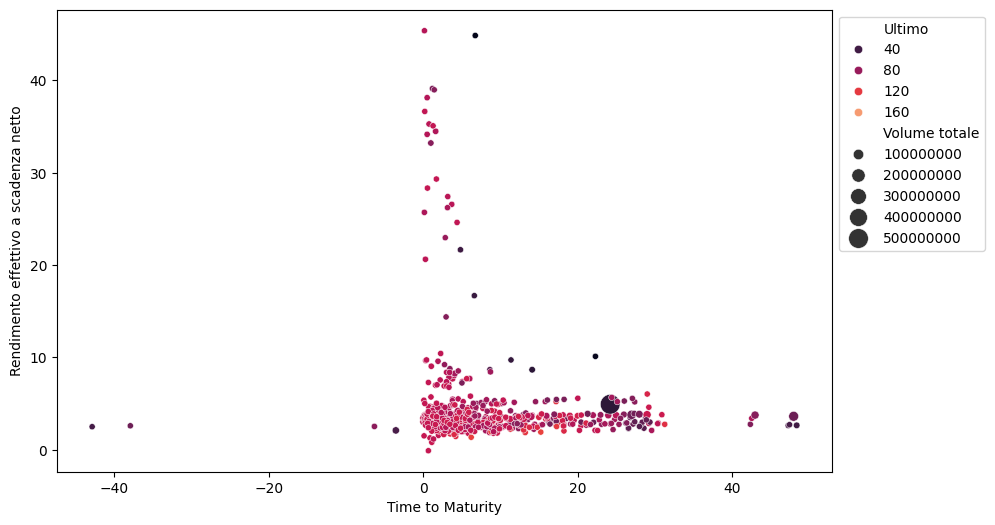

In [149]:
#scatter plot con asse X "Time to Maturity", asse Y "Rendimento effettivo a scadenza netto", grandezza bolla "Volume Totale", hue "Ultimo"

fig=plt.figure(figsize=(10,6))
ax=sns.scatterplot(data=df_volume, x="Time to Maturity", y="Rendimento effettivo a scadenza netto", hue="Ultimo", size="Volume totale", palette=sns.color_palette("rocket", as_cmap=True), sizes=(20, 200))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))



Facciamo focus su titoli con irr superiori al 10%

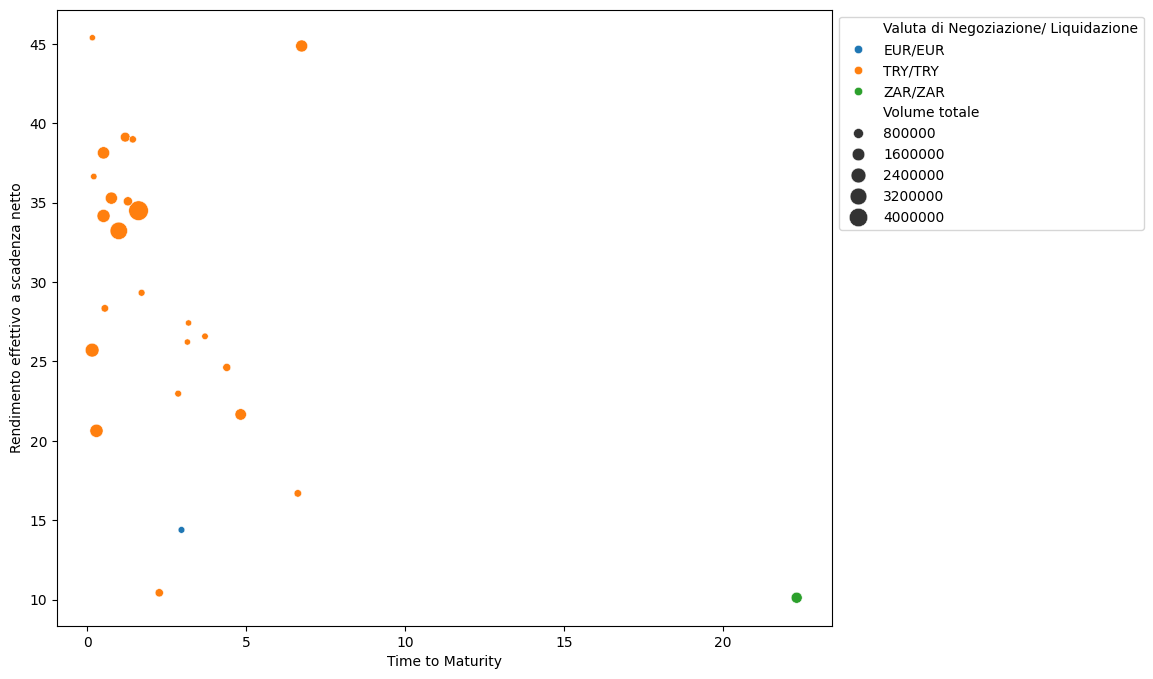

In [150]:
df_10=df[['Isin','Time to Maturity', 'Rendimento effettivo a scadenza netto','Valuta di Negoziazione/ Liquidazione',"Volume totale"]][(df['Rendimento effettivo a scadenza netto']>10)&(df['Volume totale']>10)]
fig=plt.figure(figsize=(10,8))
ax=sns.scatterplot(data=df_10, x="Time to Maturity", y="Rendimento effettivo a scadenza netto", hue="Valuta di Negoziazione/ Liquidazione", size="Volume totale",  sizes=(20, 200))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))



I titoli con rendimenti superiori al 10% sono titoli di stato in valuta messicana (MXN) e valuta turca, ultra svalutata (TRY)

Vediamo allora i titoli EUR/EUR come si comportano

In [151]:
# scatter plot matrix
df_scatter_matrix=df[['Ultimo','Tasso Cedola su base Annua','Time to Maturity',\
                      'Duration modificata',\
                        'Rendimento effettivo a scadenza netto','Volume Ultimo', 'Volume totale', 'Numero Contratti','Tipologia','NPV']]
df_scatter_matrix=df_scatter_matrix[(df_scatter_matrix['Volume Ultimo']<df_scatter_matrix['Volume Ultimo'].quantile(0.99))&(df_scatter_matrix['Time to Maturity']>0)&(df['Valuta di Negoziazione/ Liquidazione']=='EUR/EUR')&(df['Volume totale']>0)]



<Figure size 1000x800 with 0 Axes>

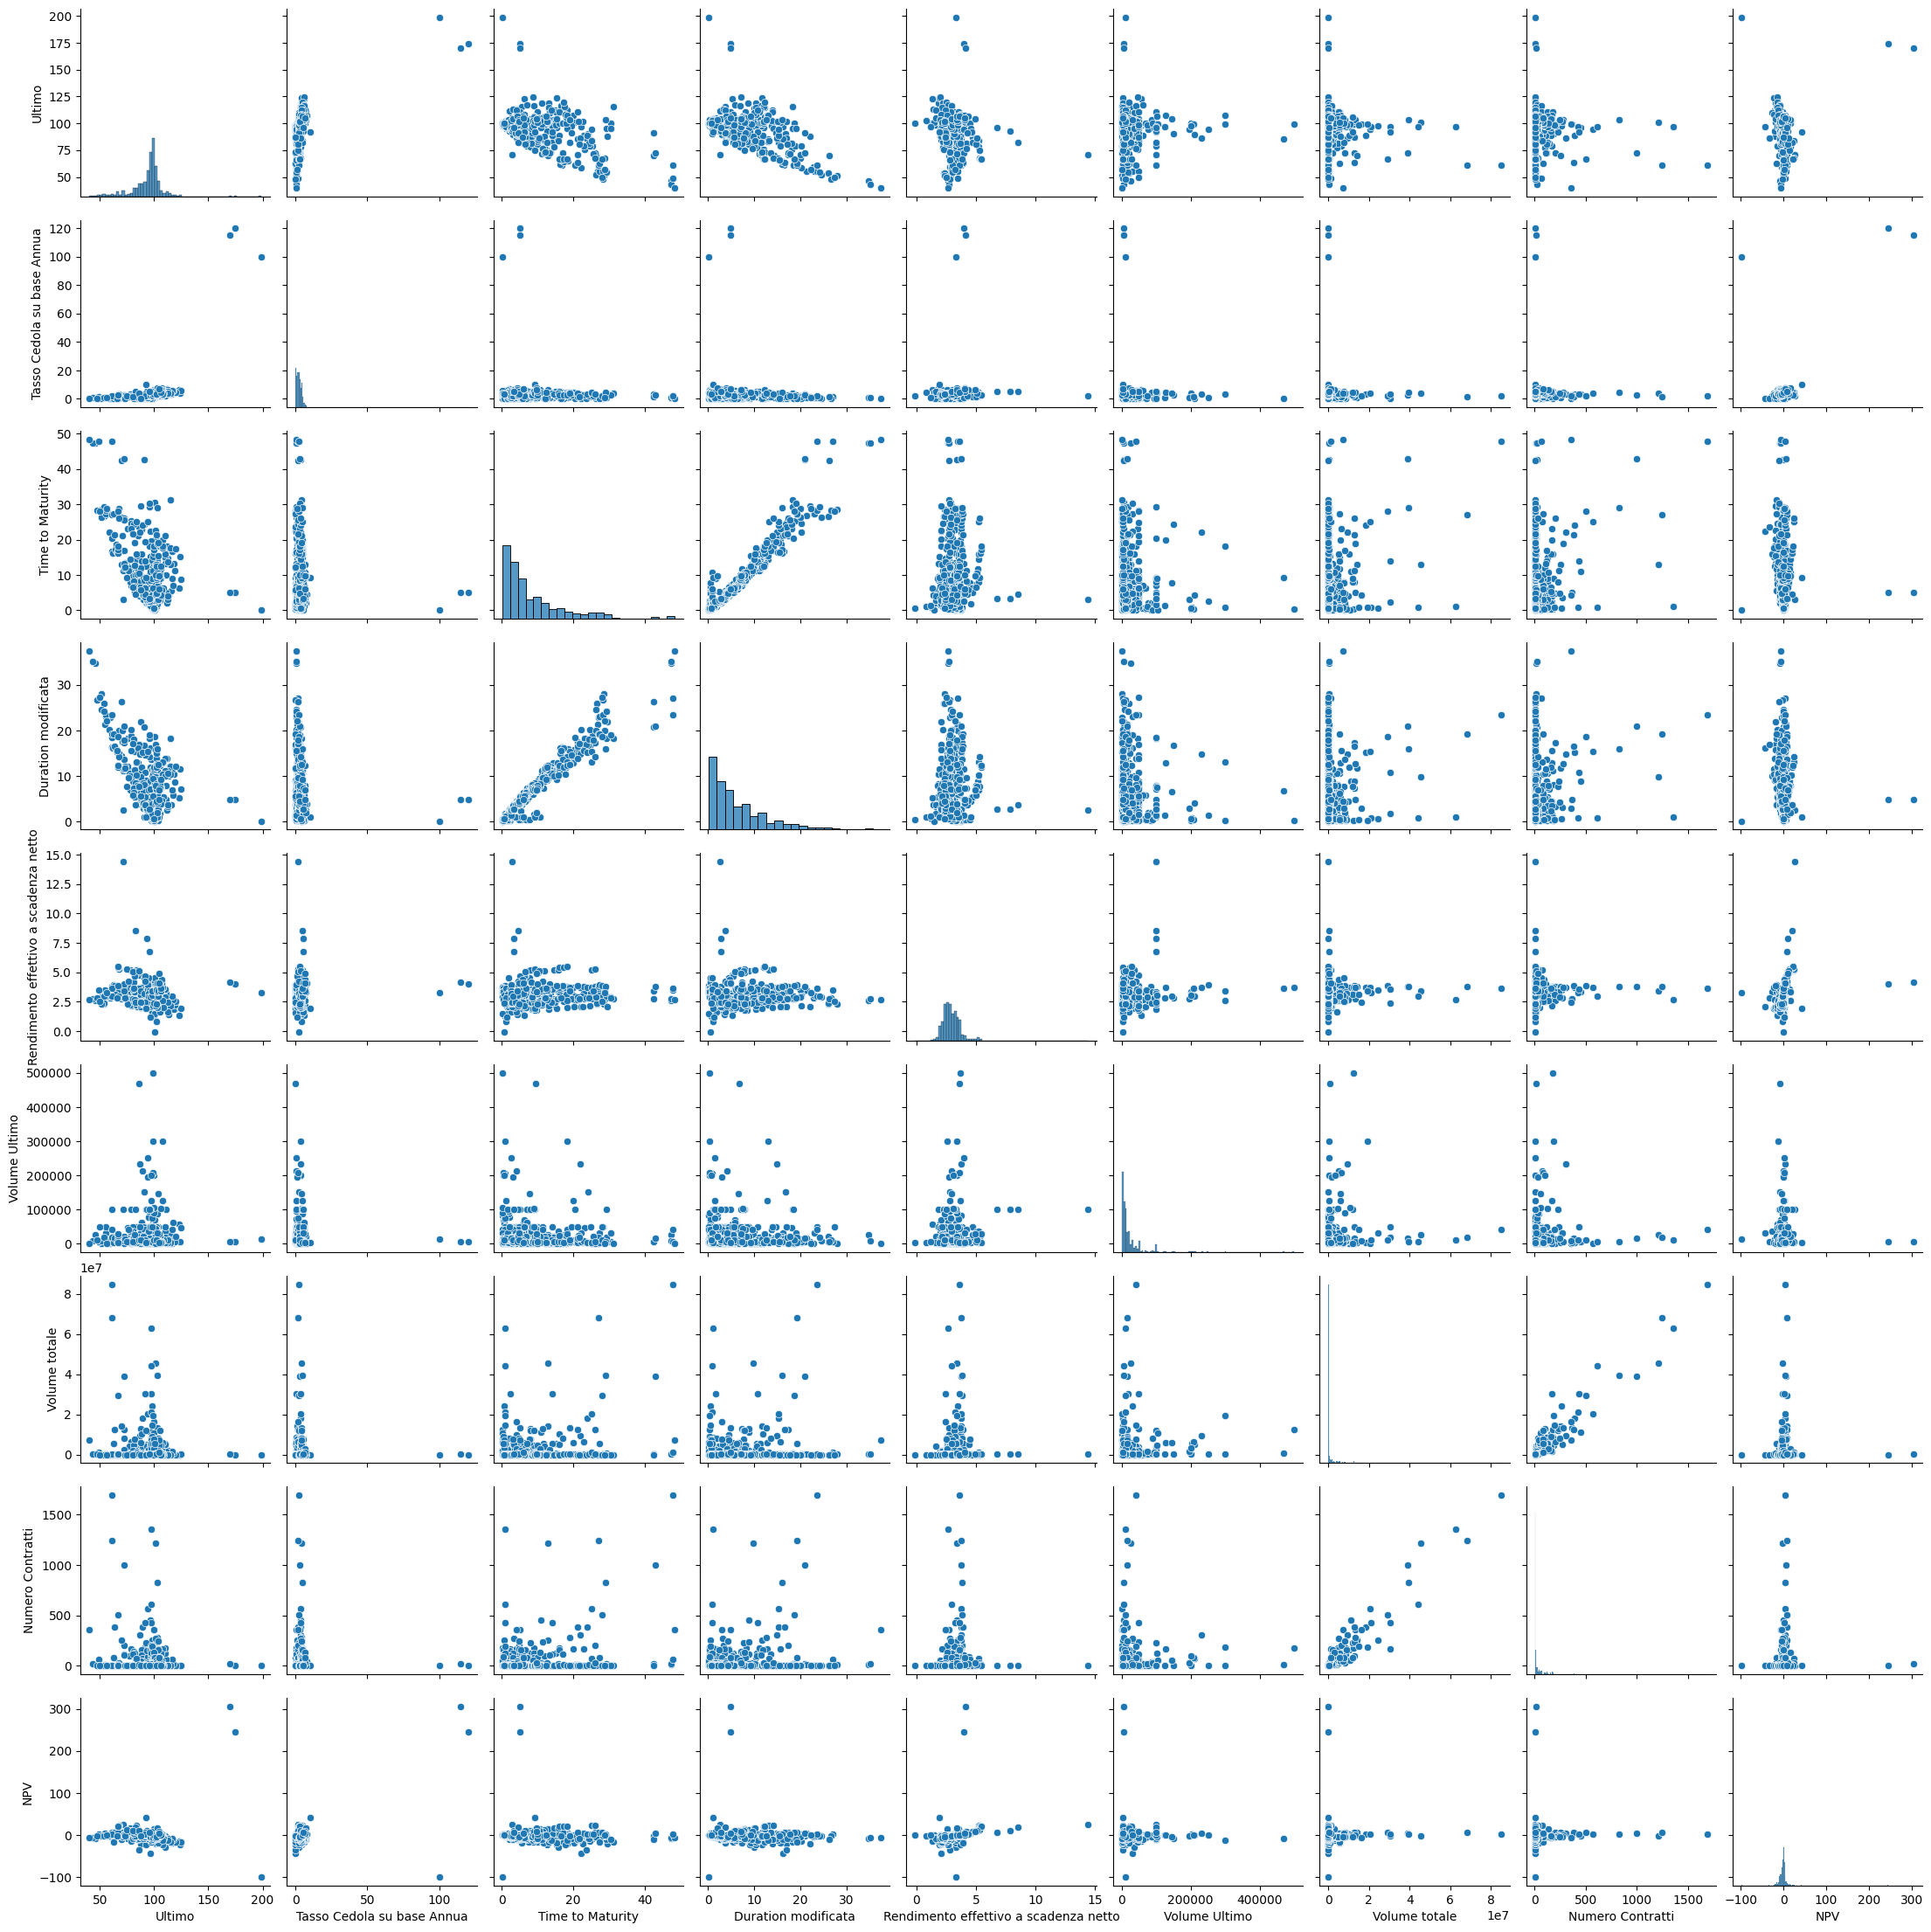

In [152]:
fig=plt.figure(figsize=(10,8))
ax=sns.pairplot(df_scatter_matrix)

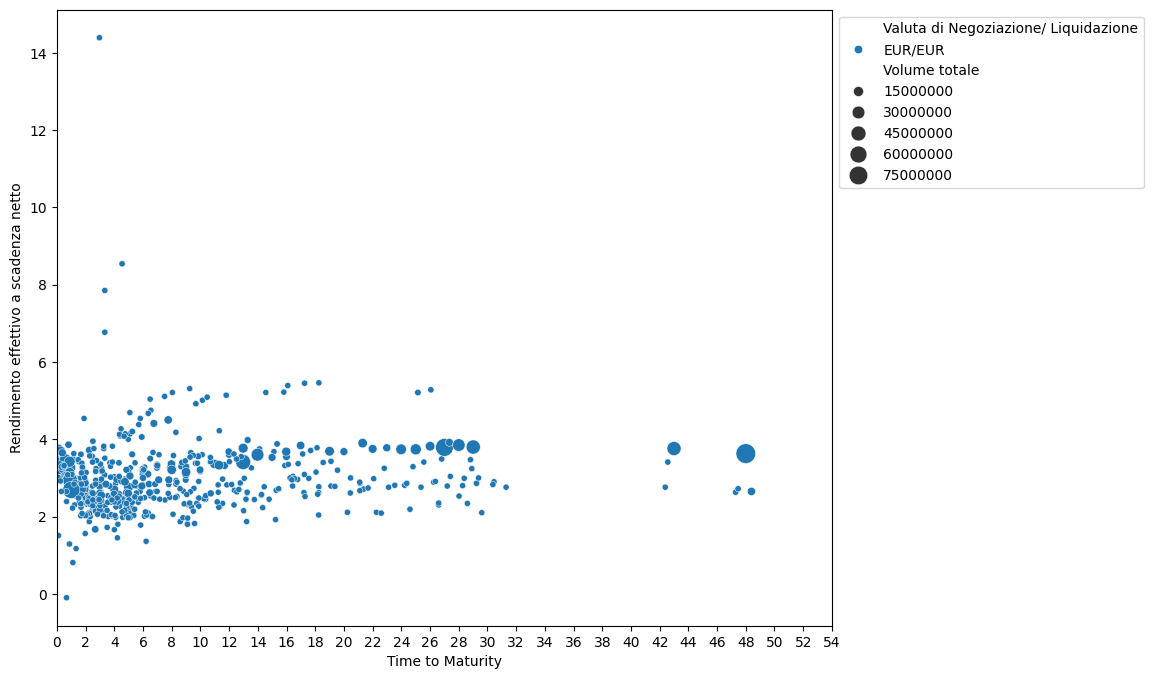

In [153]:
#time to maturity v irr
df_eur=df[['Isin','Ultimo','Time to Maturity', 'Duration modificata','Rendimento effettivo a scadenza netto','Valuta di Negoziazione/ Liquidazione',"Numero Contratti","Volume totale",'Tasso Cedola su base Annua','Tipologia','Emittente','NPV']][(df['Valuta di Negoziazione/ Liquidazione']=='EUR/EUR')&(df['Volume totale']>0)]
fig=plt.figure(figsize=(10,8))
ax=sns.scatterplot(data=df_eur, x="Time to Maturity", y="Rendimento effettivo a scadenza netto", hue="Valuta di Negoziazione/ Liquidazione", size="Volume totale",  sizes=(20, 200))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(0,None)
ax.set_xticks(list(range(0,55,2)))

Analizziamo bond con scadenza maggiore di 2 anni e rendimento maggiore di 4%

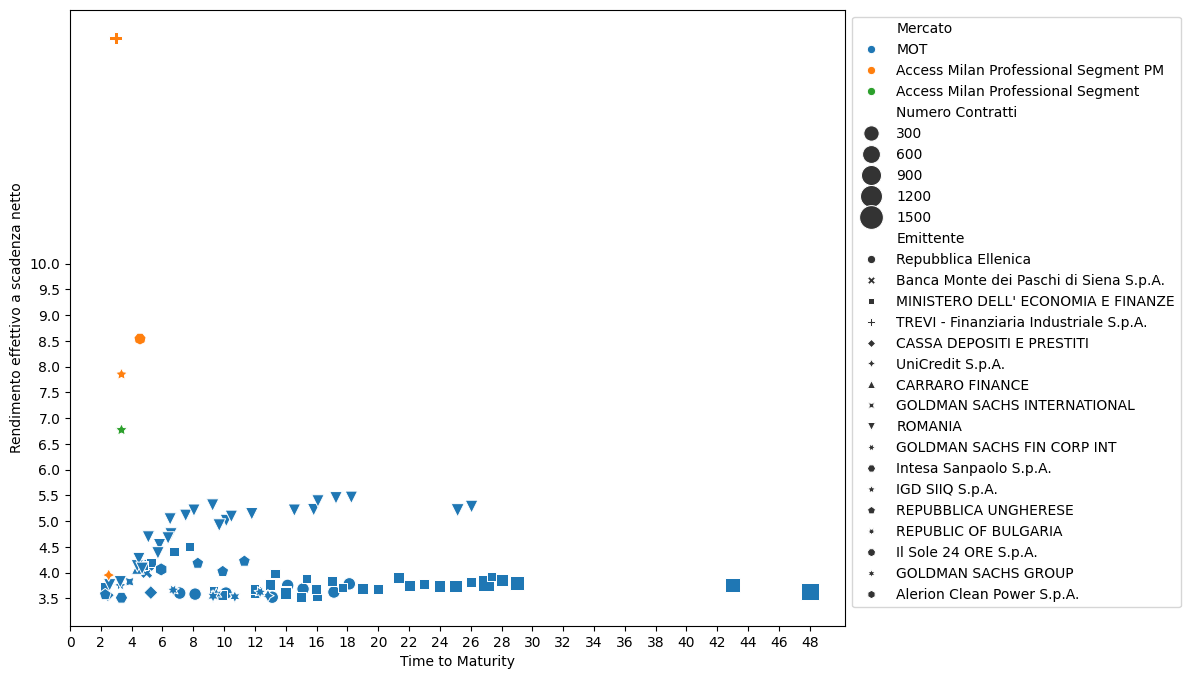

In [154]:
condizioni_eur_4=(df['Valuta di Negoziazione/ Liquidazione']=='EUR/EUR')&(df['Volume totale']>0)&(df['Rendimento effettivo a scadenza netto']>3.5)&(df['Time to Maturity']>2)
df_eur_4=df[['Isin','Ultimo','Time to Maturity', 'Duration modificata', 'Numero Contratti','Rendimento effettivo a scadenza netto','Tasso Cedola su base Annua','Valuta di Negoziazione/ Liquidazione',"Volume totale",'Mercato', 'Emittente','NPV']][condizioni_eur_4]
fig=plt.figure(figsize=(10,8))
ax=sns.scatterplot(data=df_eur_4, x="Time to Maturity", y="Rendimento effettivo a scadenza netto", hue='Mercato', size="Numero Contratti", style='Emittente', sizes=(80, 320))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(0,None)
tick_x=list(np.arange(0,50,2))
ax.set_xticks(tick_x)
tick_y=list(np.linspace(3.5,10,int((10-3.5)//0.5+1)))
ax.set_yticks(tick_y)

In [155]:
df_eur_4=df_eur_4.sort_values(['Rendimento effettivo a scadenza netto'],ascending=False)
df_eur_4.iloc[1:20,:]

,Isin,Ultimo,Time to Maturity,Duration modificata,Numero Contratti,Rendimento effettivo a scadenza netto,Tasso Cedola su base Annua,Valuta di Negoziazione/ Liquidazione,Volume totale,Mercato,Emittente,NPV
1731,XS2355600110,82.60,4.540549,3.66,3.0,8.54,4.950,EUR/EUR,300000.0,Access Milan Professional Segment PM,Il Sole 24 ORE S.p.A.,19.864436
1589,XS2084425466,93.00,3.337810,2.80,1.0,7.85,5.500,EUR/EUR,100000.0,Access Milan Professional Segment PM,IGD SIIQ S.p.A.,10.026614
1954,XS2717313964,96.00,3.337810,2.83,3.0,6.77,5.500,EUR/EUR,300000.0,Access Milan Professional Segment,IGD SIIQ S.p.A.,7.026614
1737,XS2364200514,66.39,18.255618,12.27,6.0,5.46,2.875,EUR/EUR,104000.0,MOT,ROMANIA,21.610060
1716,XS2330514899,66.40,17.258357,11.97,15.0,5.45,2.750,EUR/EUR,239000.0,MOT,ROMANIA,20.894696
1659,XS2258400162,66.42,16.088494,12.24,1.0,5.39,2.625,EUR/EUR,24000.0,MOT,ROMANIA,20.296635
1715,XS2330503694,74.50,9.252878,7.79,7.0,5.31,2.000,EUR/EUR,26000.0,MOT,ROMANIA,13.665114
1603,XS2109813142,67.71,26.055618,14.17,34.0,5.28,3.375,EUR/EUR,447000.0,MOT,ROMANIA,23.306887
1500,XS1892127470,83.54,15.811782,10.14,17.0,5.22,4.125,EUR/EUR,201000.0,MOT,ROMANIA,17.086742
1602,XS2109812508,77.91,8.041919,6.86,2.0,5.21,2.000,EUR/EUR,46000.0,MOT,ROMANIA,11.420068


Vediamo anche un po' di info Generali

In [156]:
#chi appare di più per numerosità
# df_emittente=df.groupby('Emittente').count()['Isin'].sort_values(ascending=False)
# df_volumi=df.groupby('Emittente').sum()['Numero Contratti'].sort_values(ascending=False)
# df_emitt=pd.DataFrame([df_emittente,df_volumi]).T
# df_emitt



Analisi NPV

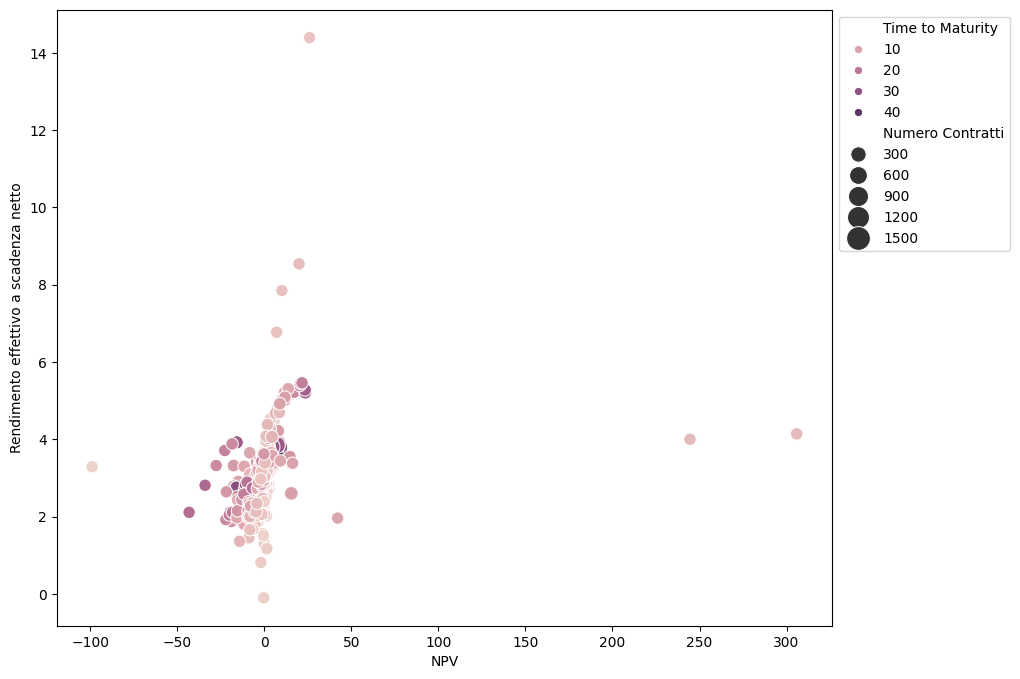

In [157]:
#facciamo ora un grafico scatter con x: npv, y: irr, hue: duration, size: contratti,  
fig=plt.figure(figsize=(10,8))
ax=sns.scatterplot(data=df_eur[df_eur['Time to Maturity']>0], x='NPV' , y="Rendimento effettivo a scadenza netto", hue="Time to Maturity", size="Numero Contratti", sizes=(80, 320))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# ax.set_xlim(0,None)
# tick_x=list(range(0,23))
# ax.set_xticks(tick_x)
# tick_y=list(np.linspace(3.5,10,int((10-3.5)//0.5+1)))
# ax.set_yticks(tick_y)



Troviamo i titoli che hanno un NPV>0 e un irr > 3.5%

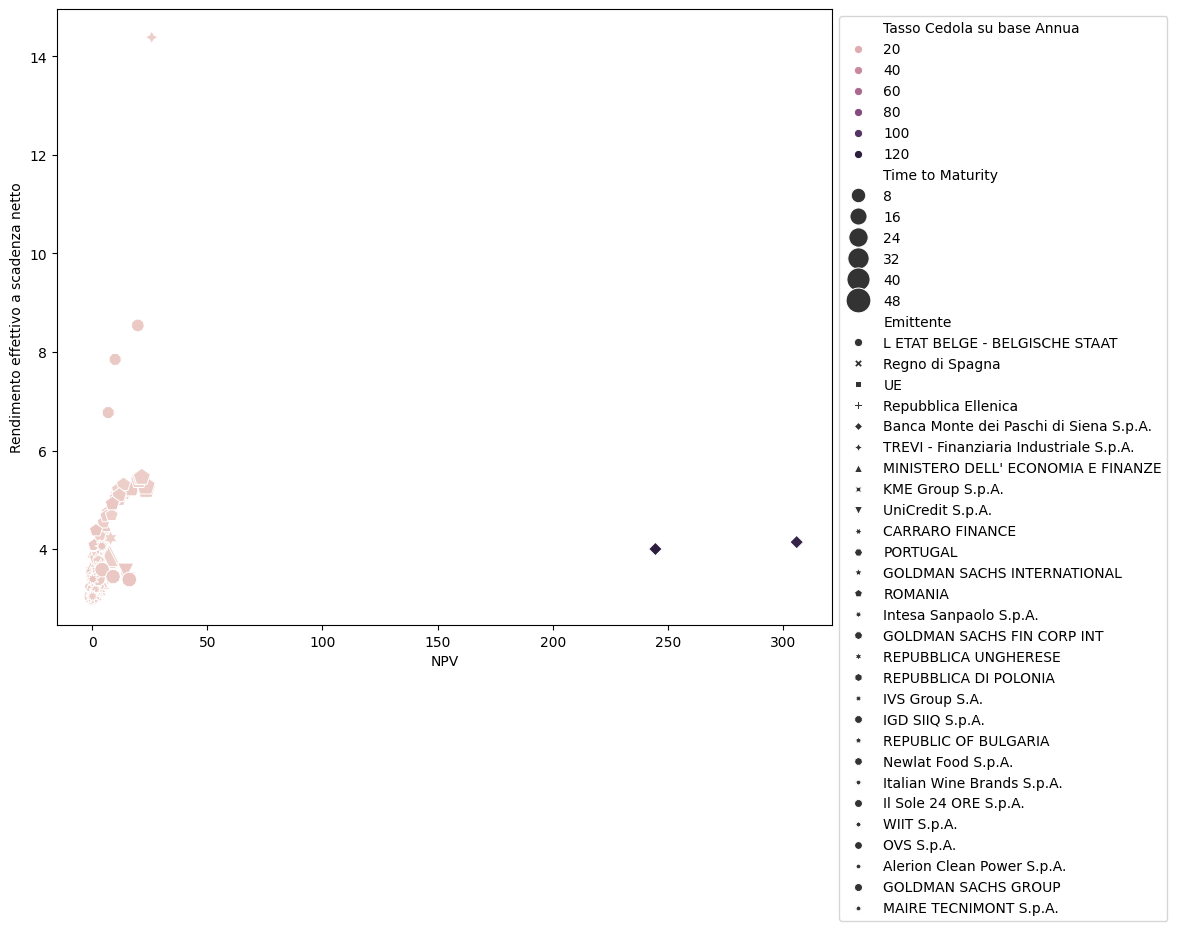

In [158]:
condizioni_eur_npv0_irr35=(df_eur['Rendimento effettivo a scadenza netto']>3)&(df_eur['Time to Maturity']>2)&((df_eur['NPV']>0))
df_eur_npv0_irr35=df_eur[condizioni_eur_npv0_irr35]
fig=plt.figure(figsize=(10,8))
ax=sns.scatterplot(data=df_eur_npv0_irr35, x='NPV' , y="Rendimento effettivo a scadenza netto", hue="Tasso Cedola su base Annua", style='Emittente',size="Time to Maturity", sizes=(80, 320))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

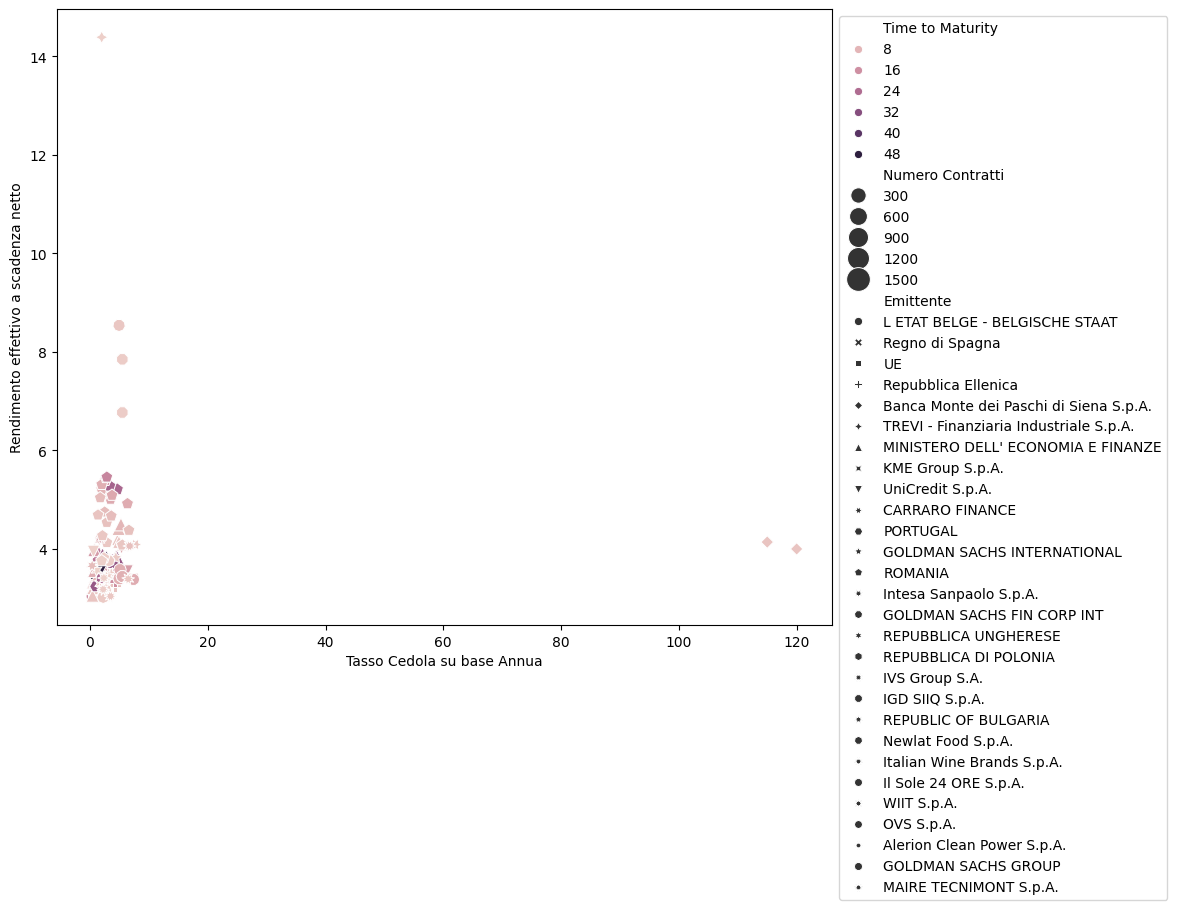

In [159]:
fig=plt.figure(figsize=(10,8))
ax=sns.scatterplot(data=df_eur_npv0_irr35, x='Tasso Cedola su base Annua' , y="Rendimento effettivo a scadenza netto", hue="Time to Maturity", style='Emittente',size="Numero Contratti", sizes=(80, 320))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [160]:
df_eur_npv0_irr35.sort_values('NPV',ascending=False).to_excel("df_eur_npv0_irr3_2.xlsx")

Focus titoli di stato italiani

In [161]:
condizioni_ita=(df['Valuta di Negoziazione/ Liquidazione']=='EUR/EUR')&(df['Volume totale']>0)&(df['Emittente']=='MINISTERO DELL\' ECONOMIA E FINANZE')&(df['Time to Maturity']>2)
df_eur_ita=df[['Isin','Ultimo','Tasso Cedola su base Annua','Time to Maturity',\
                      'Duration modificata',\
                        'Rendimento effettivo a scadenza netto','Volume Ultimo', 'Volume totale','Tipologia', 'Numero Contratti','Emittente','NPV']][condizioni_ita]

df_eur_ita_npv0=df_eur_ita[(df_eur_ita['NPV']>0)]
df_eur_ita.to_excel("df_ita_npv0.xlsx")

In [162]:
df[df['Emittente']=='MINISTERO DELL\' ECONOMIA E FINANZE']

,Unnamed: 0,Isin,Descrizione,Ultimo,Cedola,Scadenza,Unnamed: 6,Prezzo ufficiale,Data Pr Ufficiale,Indicizzazione,...,Codice Strumento,Data Godimento,Data Stacco prima Cedola,Periodicità cedola,Modalità di Negoziazione,Base di Calcolo,Tasso Cedola Periodale,Tasso Cedola su base Annua,Time to Maturity,NPV
559,559,IT0001086567,"Btp-1nv26 7,25%",111.75,3.625,2026-01-11,NaN,111.42022,11/01/24,NaN,...,21319.0,01/11/96,01/11/96,Semestrale,Corso Secco,ACT/ACT (PERIODIC BASIS),3.625,7.250,1.992604,-9.453883
560,560,IT0001174611,"Btp-1nv27 6,5%",112.81,3.250,2027-01-11,NaN,112.37781,11/01/24,NaN,...,21291.0,01/11/97,01/11/97,Semestrale,Corso Secco,ACT/ACT (PERIODIC BASIS),3.250,6.500,2.992604,-9.346620
564,564,IT0001278511,"Btp-1nv29 5,25%",111.10,2.625,2029-01-11,NaN,110.51107,11/01/24,NaN,...,21755.0,01/11/98,01/11/98,Semestrale,Corso Secco,ACT/ACT (PERIODIC BASIS),2.625,5.250,4.995344,-7.810368
569,569,IT0001444378,Btp-1mg31 6%,117.22,3.000,2031-01-05,NaN,116.58263,11/01/24,NaN,...,21563.0,01/11/99,01/11/99,Semestrale,Corso Secco,ACT/ACT (PERIODIC BASIS),3.000,6.000,6.978905,-9.419244
570,570,IT0003256820,"Btp-1fb33 5,75%",116.67,2.875,2033-01-02,NaN,115.91258,11/01/24,NaN,...,188555.0,01/02/02,01/02/02,Semestrale,Corso Secco,ACT/ACT (PERIODIC BASIS),2.875,5.750,8.973426,-7.860286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,1104,US465410CA47,"Italy Tf 1,25% Fb26 Usd",NaN,NaN,2026-02-17,NaN,92.16000,11/01/24,NaN,...,877057.0,24/11/20,24/11/20,Semestrale,Corso Secco,30E/360,NaN,1.250,2.093974,NaN
1105,1105,US465410CC03,"Italy Tf 3,875% Mg51 Usd",74.50,NaN,2051-06-05,NaN,74.50000,11/01/24,NaN,...,889271.0,06/05/21,06/05/21,Semestrale,Corso Secco,30E/360,NaN,3.875,27.406303,23.071668
1106,1106,US465410CD85,"Italy Tf 0,875% Mg24 Usd",NaN,NaN,2024-06-05,NaN,97.86800,11/01/24,NaN,...,889272.0,06/05/21,06/05/21,Semestrale,Corso Secco,30E/360,NaN,0.875,0.389864,NaN
1151,1151,XS0098449456,Italy 29eur Frn,104.41,NaN,2029-06-28,NaN,103.77837,11/01/24,NaN,...,21541.0,28/06/99,28/06/99,Annuale,Corso Secco,ACT/ACT (ANNUALLY BASIS),NaN,4.250,5.455618,-3.745942


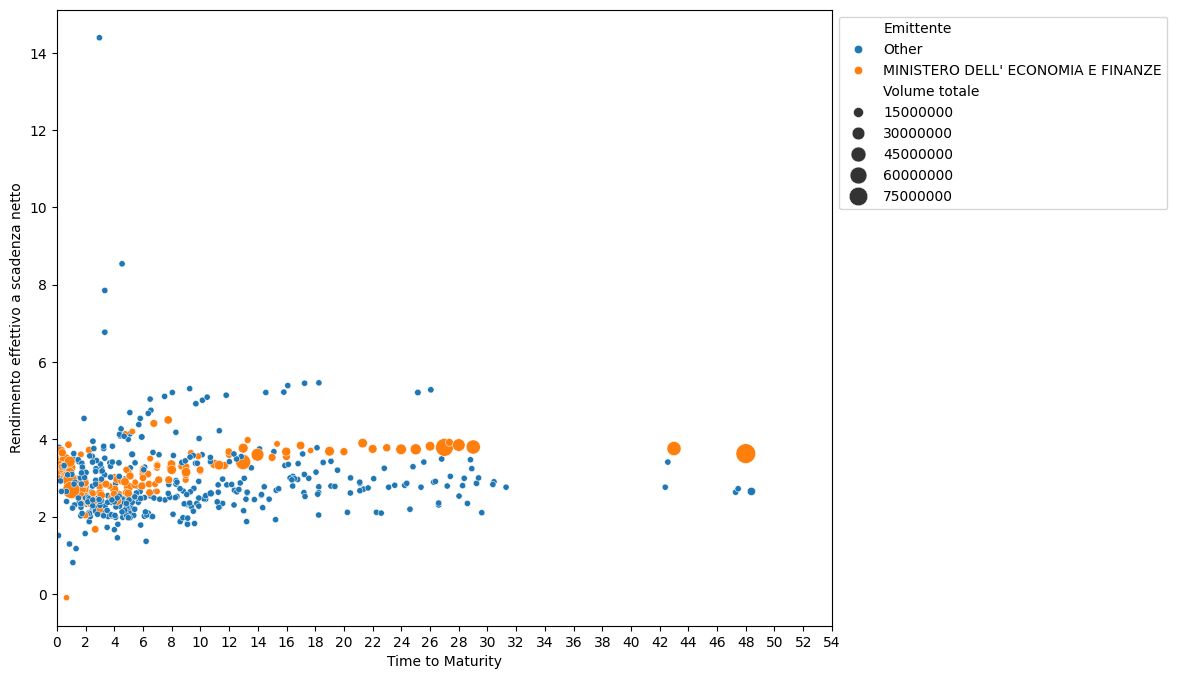

In [163]:
df_plot_temp=df_eur
df_plot_temp['Emittente']=df_plot_temp['Emittente'].where(df_plot_temp['Emittente']=="MINISTERO DELL\' ECONOMIA E FINANZE",'Other')
fig=plt.figure(figsize=(10,8))
ax=sns.scatterplot(data=df_eur, x="Time to Maturity", y="Rendimento effettivo a scadenza netto", hue="Emittente", size="Volume totale",  sizes=(20, 200))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(0,None)
ax.set_xticks(list(range(0,55,2)))

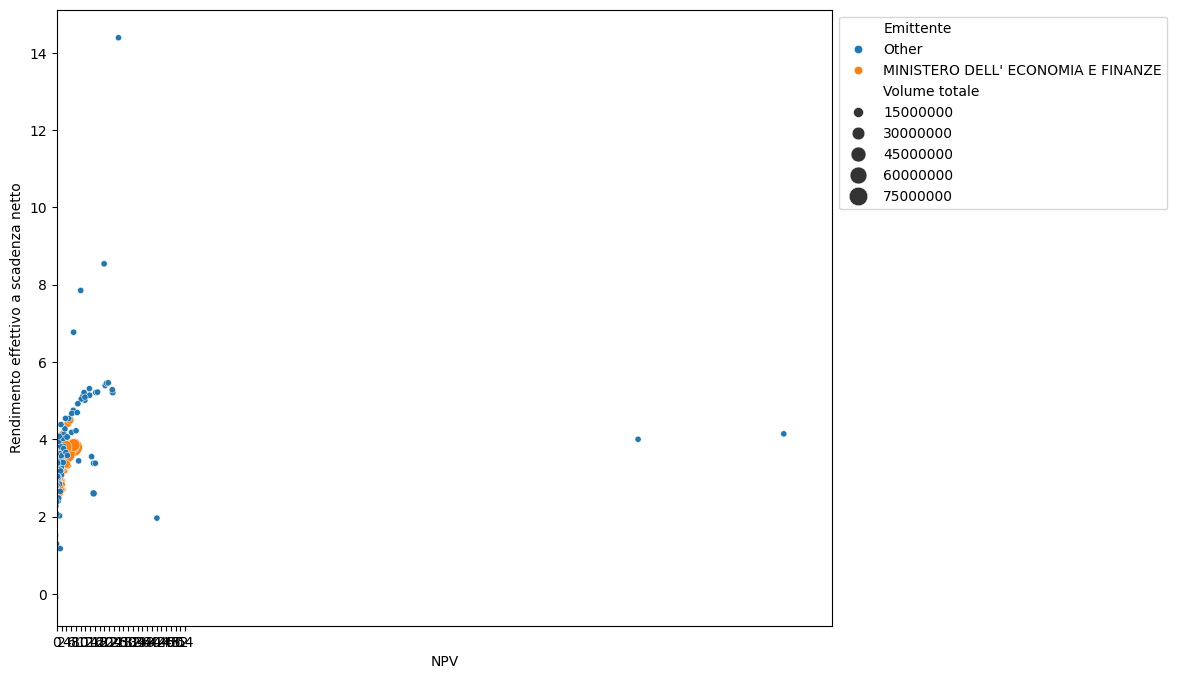

In [164]:
fig=plt.figure(figsize=(10,8))
ax=sns.scatterplot(data=df_eur, x="NPV", y="Rendimento effettivo a scadenza netto", hue="Emittente", size="Volume totale",  sizes=(20, 200))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(0,None)
ax.set_xticks(list(range(0,55,2)))

Titoli potenziali da comprare:
- XS2330503694, titolo rumeno con scadenza tra 9 anni. però poco scambiato (5 contratti). Tasso 2% su base annua. 
- IT0005554982, ccteu ancorato all'euribond. scadenza tra 8 anni. Scambiato molto di più.
- Magari qeullo di unicredit 

In [165]:
df_eur.loc[df['Isin']=='IT0005554982']

,Isin,Ultimo,Time to Maturity,Duration modificata,Rendimento effettivo a scadenza netto,Valuta di Negoziazione/ Liquidazione,Numero Contratti,Volume totale,Tasso Cedola su base Annua,Tipologia,Emittente,NPV
912,IT0005554982,100.2,7.754248,0.48,4.5,EUR/EUR,67.0,7474000.0,5.271,Titoli di stato italiani,MINISTERO DELL' ECONOMIA E FINANZE,5.410619
